# Approaching and analyzing tree models

#### Goal: being able to tell the dependencies within the dataset, reliably predict PM2.5. Explore weaknesses of the selected model.

## Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import Pool

import joblib
import shap

## Seed for reproducability

In [37]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

## Data import

In [38]:
data_folder_path = "data\DataHourlyChina"
TARGET = "PM2.5"
RANDOM_SEED = 42
seed_everything(seed=RANDOM_SEED)

df = pd.read_csv(os.path.join(data_folder_path, "POST_EDA_POST_FEAT_ENG_STANDARDIZED_TARGET_TRANSFORMED.csv"), index_col="datetime")
df.head()

,year,PM10,SO2,NO2,CO,O3,TEMP,RAIN,WSPM,wd_ENE,...,cos_hour,month_sin,dayofweek_sin,dayofweek_cos,TEMP_x_CO,NO2_x_RAIN,WSPM_X_SO2,PM10_diff1,TEMP_diff1,PM2.5
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-01 01:00:00,-1.412466,-1.078452,-0.593658,-1.424646,-0.809090,0.374490,-1.288641,-0.073894,2.487723,-0.356598,...,1.366067,1.423946,-0.612319,-1.275284,-0.846123,-0.075799,-0.202244,0.110008,-0.303442,2.079442
2013-03-01 02:00:00,-1.412466,-1.089070,-0.549144,-1.342647,-0.809090,0.304318,-1.288641,-0.073894,3.236048,-0.356598,...,1.224784,1.423946,-0.612319,-1.275284,-0.846123,-0.075799,0.037109,-0.027529,-0.000201,1.945910
2013-03-01 03:00:00,-1.412466,-1.099689,-0.282056,-1.315314,-0.809090,0.286775,-1.314966,-0.073894,1.157367,-0.356598,...,1.000035,1.423946,-0.612319,-1.275284,-0.852138,-0.075799,0.195810,-0.027529,-0.227632,1.791759
2013-03-01 04:00:00,-1.412466,-1.131543,-0.237542,-1.287982,-0.809090,0.286775,-1.367616,-0.073894,0.242748,-0.356598,...,0.707136,1.423946,-0.612319,-1.275284,-0.864169,-0.075799,-0.066958,-0.082543,-0.455063,1.098612
2013-03-01 05:00:00,-1.412466,-1.110307,0.029546,-1.123985,-0.725066,0.181516,-1.385166,-0.073894,1.656251,-0.356598,...,0.366048,1.423946,-0.612319,-1.275284,-0.882884,-0.075799,1.041351,0.054994,-0.151822,1.609438


Action plan is to:
- build several baseline models to choose the best ones
- select the best one(s) and fine-tune them
- merge them into an ensemble and assess
- assess feature importance
- Residual Plot for Nonlinear Models (model selection logic)

## Data Split and train function

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), df[TARGET], test_size=0.2, random_state=RANDOM_SEED)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (28045, 35)
Test shape: (7012, 35)


In [40]:
# globally, in case I have to manually interrupt to see the intermediate results
last_tuned_model = np.nan 
df_results = pd.DataFrame()
def tune_model(model_class, params: dict, x_train: pd.DataFrame, y_train: pd.Series, scoring: dict, patience: int):
    tunable_params_count = 0
    tunable_param_name = ""

    # ensure only one param is marked as tunable
    for param in params:
        if isinstance(params[param], (list, np.ndarray)):
            tunable_params_count += 1
            tunable_param_name = param

    if tunable_params_count != 1:
        print("You may use no less and no more than 1 tunable parameter with type of list / ndarray.")
        return

    # declare the result dataframe in advance (to avoid issues with pd.concat)
    params_copy = params.copy()
    df_results = pd.DataFrame({
        tunable_param_name: pd.Series(dtype='str'),
        'MAE': pd.Series(dtype='float'),
        'RMSE': pd.Series(dtype='float'),
        'R2': pd.Series(dtype='float'),
        'Time spent (min)': pd.Series(dtype='float'),
    })

    best_rmse = np.inf
    patience_counter = 0

    # for each param: cross-validate in 5-fold, time how long it takes, calculate MAE, RMSE, R2
    for idx, param_val in enumerate(params[tunable_param_name]):
        print(f"Processing {tunable_param_name} = {param_val} ...")
        params_copy[tunable_param_name] = param_val
    
        last_tuned_model = model_class(**params_copy)
    
        start_time = time.perf_counter()
        cv_results = cross_validate(last_tuned_model, x_train, y_train, cv=5, scoring=scoring, return_train_score=False)
        end_time = time.perf_counter()

        mean_cv_mae = -cv_results['test_MAE'].mean()
        mean_cv_rmse = -cv_results['test_RMSE'].mean()
        mean_cv_r2 = cv_results['test_R2'].mean()
    
        new_row_df = pd.DataFrame({tunable_param_name: [param_val],
                                   'MAE': [mean_cv_mae],
                                   'RMSE': [mean_cv_rmse],
                                   'R2': [mean_cv_r2],
                                   'Time spent (min)': [(end_time - start_time)/60],
                                   })
    
        df_results = pd.concat([df_results, new_row_df], ignore_index=True)
    
        if mean_cv_rmse < best_rmse:
            best_rmse = mean_cv_rmse
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and idx != len(params[tunable_param_name]) - 1:
                print("Early stopping triggered.")
                return df_results

    return df_results

## Progressive model selection

 - Run different model types (Random Forest, Extra Trees, LightGBM, XGBoost, CatBoost) with similar, rough parameters
 - Pick the best-performing algorithm
 - feature reduction for model optimization
 - Fine-tune only the selected model(s)

### In the process of selection, the following factors are going to be used:
- Sanity Check (if model makes sense)
- Reference Point (if a complex model doesn’t outperform a simple baseline, it’s pointless)
- Speed-value trade-off (if we get very little value by paying with computational power and time, it's pointless)

#### The metrics:
- MAE (to understand general error)
- RMSE (for outlier / big mistakes sensitivity)
- R2 (for assessing how well the model understands the data)
- Training time (although it's preliminary consumed during training, it also make the model denser and takes its toll in the inference. Additionally, we might want to maintain the relevance by training it on new data as well).

In [41]:
# custom scorers to revert log-predictions
def mae_exp(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))

scoring = {
    'MAE': make_scorer(mae_exp, greater_is_better=False),
    'RMSE': make_scorer(rmse_exp, greater_is_better=False),
    'R2': 'r2'
}

##### 1. RandomForestRegressor

In [7]:
params = {
    'max_depth': 10,          
    'n_estimators': [100, 200, 300], 
    'random_state': RANDOM_SEED,   
    'n_jobs': -1 
}

rf_results = tune_model(model_class=RandomForestRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(rf_results.T)

Processing n_estimators = 100 ...
Processing n_estimators = 200 ...
Processing n_estimators = 300 ...


,0,1,2
n_estimators,100,200,300
MAE,14.599761,14.584668,14.584996
RMSE,23.268018,23.2256,23.229052
R2,0.902084,0.902288,0.902391
Time spent (min),0.314332,0.537036,0.735112


##### 2. ExtraTreesRegressor

In [8]:
params = {
    'max_depth': 10,          
    'n_estimators': [100, 200, 300], 
    'random_state': RANDOM_SEED,   
    'n_jobs': -1
}

extra_trees_results = tune_model(model_class=ExtraTreesRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(extra_trees_results.T)

Processing n_estimators = 100 ...
Processing n_estimators = 200 ...
Processing n_estimators = 300 ...


,0,1,2
n_estimators,100,200,300
MAE,16.07209,16.037188,16.033461
RMSE,24.743599,24.724344,24.70229
R2,0.891165,0.891748,0.891709
Time spent (min),0.087565,0.145839,0.207701


##### 3. LGBMRegressor

In [9]:
params = {
    'objective': 'regression', 
    'boosting_type': 'gbdt',
    'num_leaves': 10,          
    'learning_rate': 0.1,  
    'n_estimators': [100, 200, 300], 
    'random_state': RANDOM_SEED, 
    'verbose': -1     
}

lgbm_results = tune_model(model_class=lgb.LGBMRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(lgbm_results.T)

Processing n_estimators = 100 ...
Processing n_estimators = 200 ...
Processing n_estimators = 300 ...


,0,1,2
n_estimators,100,200,300
MAE,14.933144,14.064662,13.674021
RMSE,24.799812,23.307116,22.624927
R2,0.900869,0.908306,0.912095
Time spent (min),0.017672,0.02795,0.031077


##### 4. XGBRegressor

In [10]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': 0.1,          
    'n_estimators': [100, 200, 300],
    'random_state': RANDOM_SEED,   
}

xg_boost_results = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results.T)

Processing n_estimators = 100 ...
Processing n_estimators = 200 ...
Processing n_estimators = 300 ...


,0,1,2
n_estimators,100,200,300
MAE,13.01593,12.493038,12.264342
RMSE,21.655896,20.888168,20.568519
R2,0.916758,0.92133,0.923015
Time spent (min),0.028142,0.046997,0.062274


##### 5. CatBoostRegressor

In [13]:
params = {
    'loss_function': 'RMSE',
    'n_estimators': [100, 200, 300], 
    'max_depth': 10, 
    'learning_rate': 0.1,
    'random_seed': RANDOM_SEED,
    'verbose': 0
}


cat_results = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results.T)

Processing n_estimators = 100 ...
Processing n_estimators = 200 ...
Processing n_estimators = 300 ...


,0,1,2
n_estimators,100,200,300
MAE,13.6953,12.684417,12.226125
RMSE,23.185322,21.603975,20.956646
R2,0.914216,0.922587,0.925968
Time spent (min),0.312819,0.602267,0.860276


### Results comparison

In [14]:
# Despite that the values might be from different batches, we are assessing models' capabilities.
baseline_model_results = {"RandomForestRegressor": rf_results, "ExtraTreesRegressor": extra_trees_results, "LGBMRegressor": lgbm_results, 
                          "XGBoostRegressor": xg_boost_results, "CatBoostRegressor": cat_results}
for model_name in baseline_model_results:
    model_results_df = baseline_model_results[model_name]
    print(f"{model_name}\t\t\t min MAE: {min(model_results_df['MAE'])}")
    print(f"{model_name}\t\t\t min RMSE: {min(model_results_df['RMSE'])}")
    print(f"{model_name}\t\t\t max R2: {max(model_results_df['R2'])}")
    print("---")

RandomForestRegressor			 min MAE: 14.584667973337096
RandomForestRegressor			 min RMSE: 23.225600289281154
RandomForestRegressor			 max R2: 0.9023912547519684
---
ExtraTreesRegressor			 min MAE: 16.03346101133991
ExtraTreesRegressor			 min RMSE: 24.702289771677822
ExtraTreesRegressor			 max R2: 0.8917478511675301
---
LGBMRegressor			 min MAE: 13.674020811638036
LGBMRegressor			 min RMSE: 22.62492675807318
LGBMRegressor			 max R2: 0.9120948977481766
---
XGBoostRegressor			 min MAE: 12.264341535118621
XGBoostRegressor			 min RMSE: 20.568519248772024
XGBoostRegressor			 max R2: 0.9230146582560724
---
CatBoostRegressor			 min MAE: 12.226124668596857
CatBoostRegressor			 min RMSE: 20.956646186552383
CatBoostRegressor			 max R2: 0.9259675220924584
---


### XGBoostRegressor and CatBoostRegressor clearly outperform others with the latter being superior. 
## Tuning

In [42]:
best_xgbRegressor_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'n_estimators': 0,
    'learning_rate': 0,
    'random_state': RANDOM_SEED,
}

best_catBoostRegressor_params = {
    'loss_function': 'RMSE',
    'n_estimators': 0,
    'max_depth': 0,
    'learning_rate': 0,
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

#### Tuning XGBRegressor's n_estimators:

In [46]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': 0.1,         
    'n_estimators': [1000, 3000, 6000, 10000, 15000, 18000],
    'random_state': RANDOM_SEED,   
}

xg_boost_results2 = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results2.T)

Processing n_estimators = 1000 ...
Processing n_estimators = 3000 ...
Processing n_estimators = 6000 ...
Processing n_estimators = 10000 ...
Processing n_estimators = 15000 ...
Early stopping triggered.


,0,1,2,3,4
n_estimators,1000,3000,6000,10000,15000
MAE,11.763538,11.609176,11.595269,11.595269,11.595269
RMSE,19.906403,19.744917,19.73731,19.73731,19.73731
R2,0.925788,0.92621,0.926243,0.926243,0.926243
Time spent (min),0.201944,0.592843,1.244655,1.282435,1.526943


##### While the optimal value appears to lie in n_estimators>=10.000, starting from 6000, we have way more estimators added and time spent for the insignificant trade-off. 

##### The further interval being researched is [3000;6000):

In [56]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': 0.1,        
    'n_estimators': [3000, 3500, 4000, 4500, 5000, 5500],
    'random_state': RANDOM_SEED,   
}

xg_boost_results3 = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results3.T)

Processing n_estimators = 3000 ...
Processing n_estimators = 3500 ...
Processing n_estimators = 4000 ...
Processing n_estimators = 4500 ...
Processing n_estimators = 5000 ...
Processing n_estimators = 5500 ...


,0,1,2,3,4,5
n_estimators,3000,3500,4000,4500,5000,5500
MAE,11.609176,11.603061,11.599356,11.594969,11.594964,11.595217
RMSE,19.744917,19.740791,19.740467,19.735336,19.735844,19.736791
R2,0.92621,0.926239,0.926242,0.926249,0.926253,0.926248
Time spent (min),0.531113,0.602703,0.706599,0.844127,0.874247,0.968214


##### 4500 < n_estimators <= 5000

In [59]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': 0.1,        
    'n_estimators': [4600, 4700, 4800, 4900],
    'random_state': RANDOM_SEED,   
}

xg_boost_results4 = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results4.T)

Processing n_estimators = 4600 ...
Processing n_estimators = 4700 ...
Processing n_estimators = 4800 ...
Processing n_estimators = 4900 ...


,0,1,2,3
n_estimators,4600,4700,4800,4900
MAE,11.595112,11.595069,11.595116,11.594645
RMSE,19.735449,19.734836,19.735201,19.735151
R2,0.92625,0.926251,0.926248,0.926252
Time spent (min),0.796671,0.773792,0.783018,0.801356


In [43]:
best_xgbRegressor_params['n_estimators'] = 4900

#### Tuning XGBRegressor's learning rate

In [63]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],          
    'n_estimators': 4900,
    'random_state': RANDOM_SEED,   
}

xg_boost_results5 = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results5.T)

Processing learning_rate = 0.05 ...
Processing learning_rate = 0.1 ...
Processing learning_rate = 0.15 ...
Early stopping triggered.


,0,1,2
learning_rate,0.050000,0.100000,0.150000
MAE,11.540096,11.594645,11.791349
RMSE,19.555393,19.735151,19.900634
R2,0.926742,0.926252,0.924380
Time spent (min),0.964828,1.033259,0.880278


#### The optimum is <= 0.05:

In [66]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': [0.01, 0.02, 0.03, 0.04],          
    'n_estimators': 5000,
    'random_state': RANDOM_SEED,   
}

xg_boost_results6 = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results6.T)

Processing learning_rate = 0.01 ...
Processing learning_rate = 0.02 ...
Processing learning_rate = 0.03 ...
Processing learning_rate = 0.04 ...


,0,1,2,3
learning_rate,0.010000,0.020000,0.030000,0.040000
MAE,11.986709,11.714756,11.590504,11.572544
RMSE,20.233754,19.859967,19.676781,19.709994
R2,0.924693,0.926125,0.926546,0.926775
Time spent (min),0.921023,0.903683,0.904956,0.905582


#### 0.05 is the best option here.

In [44]:
best_xgbRegressor_params['learning_rate'] = 0.05

#### Tuning CatBoostRegressor's max_depth

In [17]:
params = {
    'n_estimators': 200,
    'max_depth': [10, 12, 14, 16],
    'learning_rate': 0.1, 
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results2 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results2.T)

Processing max_depth = 10 ...
Processing max_depth = 12 ...
Processing max_depth = 14 ...
Processing max_depth = 16 ...


,0,1,2,3
max_depth,10,12,14,16
MAE,12.684417,12.27463,12.176202,12.677481
RMSE,21.603975,21.431761,21.835232,23.627023
R2,0.922587,0.925859,0.926423,0.922599
Time spent (min),0.600401,1.792613,6.826253,26.268968


##### The trade-off between the increasing in score and the spent time is not justified.

In [19]:
params = {
    'n_estimators': 200,
    'max_depth': [13],
    'learning_rate': 0.1, 
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results3 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results3.T)

Processing max_depth = 13 ...


,0
max_depth,13
MAE,12.156796
RMSE,21.49262
R2,0.926846
Time spent (min),3.401208


In [45]:
best_catBoostRegressor_params['max_depth'] = 12

#### Tuning CatBoostRegressor's learning_rate

In [ ]:
params = {
    'n_estimators': 200,
    'max_depth': 12,
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results4 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results4.T)

Processing learning_rate = 0.05 ...
Processing learning_rate = 0.1 ...
Processing learning_rate = 0.15 ...
Processing learning_rate = 0.2 ...
Processing learning_rate = 0.25 ...


,0,1,2,3,4
learning_rate,0.050000,0.100000,0.150000,0.200000,0.250000
MAE,13.023230,12.274630,12.077057,12.068629,12.138408
RMSE,22.474393,21.431761,21.220744,21.124688,21.300223
R2,0.919775,0.925859,0.927619,0.926898,0.925969
Time spent (min),1.762619,1.768854,1.783570,1.732717,1.760451


#### The optimal value is in [0.15;0.25)

In [ ]:
params = {
    'n_estimators': 200,
    'max_depth': 12,
    'learning_rate': [0.15, 0.17, 0.19, 0.21, 0.23],
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results5 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results5.T)

Processing learning_rate = 0.15 ...
Processing learning_rate = 0.17 ...
Processing learning_rate = 0.19 ...
Processing learning_rate = 0.21 ...
Processing learning_rate = 0.23 ...


,0,1,2,3,4
learning_rate,0.150000,0.170000,0.190000,0.210000,0.230000
MAE,12.077057,12.095958,12.040121,12.037169,12.171891
RMSE,21.220744,21.159923,21.160723,21.124964,21.251899
R2,0.927619,0.927022,0.927124,0.926577,0.925683
Time spent (min),1.715757,1.688673,1.699684,1.728914,1.746747


#### The optimal value is between [0.21;0.23)

In [ ]:
params = {
    'n_estimators': 200,
    'max_depth': 12,
    'learning_rate': [0.22, 0.225],
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results6 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results6.T)

Processing learning_rate = 0.22 ...
Processing learning_rate = 0.225 ...


,0,1
learning_rate,0.220000,0.225000
MAE,12.080715,12.165403
RMSE,21.056659,21.174450
R2,0.927017,0.926531
Time spent (min),1.839822,1.909777


In [46]:
best_catBoostRegressor_params['learning_rate'] = 0.22

#### Tuning CatBoostRegressor's n_estimators:

In [ ]:
params = {
    'n_estimators': [100, 500, 700, 1000],
    'max_depth': 12,
    'learning_rate': 0.22,
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results7 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results7.T)

Processing n_estimators = 100 ...
Processing n_estimators = 500 ...
Processing n_estimators = 700 ...
Processing n_estimators = 1000 ...


,0,1,2,3
n_estimators,100,500,700,1000
MAE,12.726082,11.735717,11.679337,11.652996
RMSE,22.023805,20.611838,20.547393,20.526896
R2,0.923031,0.929074,0.929308,0.929381
Time spent (min),0.895809,5.170615,7.421228,11.013475


##### We may try a couple more:

In [67]:
params = {
    'n_estimators': [1500, 2000],
    'max_depth': 12,
    'learning_rate': 0.22,
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results7 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results7.T)

Processing n_estimators = 1500 ...
Processing n_estimators = 2000 ...


,0,1
n_estimators,1500,2000
MAE,11.643128,11.641903
RMSE,20.516787,20.515921
R2,0.929427,0.929433
Time spent (min),14.84108,19.577585


##### The trade-off between the increasing in score and the spent time is not justified.

In [47]:
best_catBoostRegressor_params['n_estimators'] = 1500

## Permutation importance

In [ ]:
best_catBoostRegressor_params
# {'loss_function': 'RMSE',
#  'n_estimators': 1500,
#  'max_depth': 12,
#  'learning_rate': 0.22,
#  'random_seed': 42,
#  'verbose': 0}

{'loss_function': 'RMSE',
 'n_estimators': 1500,
 'max_depth': 12,
 'learning_rate': 0.22,
 'random_seed': 42,
 'verbose': 0}

##### Training the best model to assess features (CatBoost)

In [30]:
best_cat_model = CatBoostRegressor(**best_catBoostRegressor_params)
best_cat_model.fit(X_train, y_train)
best_cat_model_predictions = best_cat_model.predict(X_test)
    
mae = mae_exp(y_test, best_cat_model_predictions)
rmse = rmse_exp(y_test, best_cat_model_predictions)
r2 = r2_score(y_test, best_cat_model_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 11.003020145651883
Test 	RMSE: 19.45317906086391
Test 	R2: 0.9355511696359798


##### Render the importance

In [ ]:
r = permutation_importance(best_cat_model, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED)
imp_cat = pd.Series(r.importances_mean, index=X_test.columns)
imp_cat.sort_values(ascending=False)

PM10             0.762121
CO               0.189496
TEMP_x_CO        0.051373
NO2              0.043758
year             0.029855
O3               0.027466
month_sin        0.026365
TEMP             0.024195
PM10_diff1       0.014114
SO2              0.014091
sin_hour         0.012171
dayofweek_sin    0.008523
dayofweek_cos    0.008173
WSPM_X_SO2       0.006007
WSPM             0.005896
cos_hour         0.005288
TEMP_diff1       0.003836
NO2_x_RAIN       0.000973
is_weekend       0.000649
wd_SW            0.000254
wd_ENE           0.000163
wd_N             0.000147
wd_NW            0.000129
wd_WSW           0.000125
RAIN             0.000118
wd_SSW           0.000108
wd_NE            0.000093
wd_NNW           0.000062
wd_WNW           0.000060
wd_S             0.000049
wd_W             0.000048
wd_SE            0.000041
wd_ESE           0.000019
wd_SSE           0.000011
wd_NNE          -0.000023
dtype: float64

##### Features with importance < 0.001 will be considered redundant

In [ ]:
imp_cat[imp_cat<0.001].index

Index(['RAIN', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW',
       'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'is_weekend', 'NO2_x_RAIN'],
      dtype='object')

##### Training the best model without features of lesser importance

In [33]:
best_cat_model = CatBoostRegressor(**best_catBoostRegressor_params)
best_cat_model.fit(X_train.drop(columns=['RAIN', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW',
       'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'is_weekend', 'NO2_x_RAIN']), y_train)
best_cat_model_predictions = best_cat_model.predict(X_test.drop(columns=['RAIN', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW',
       'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'is_weekend', 'NO2_x_RAIN']))
    
mae = mae_exp(y_test, best_cat_model_predictions)
rmse = rmse_exp(y_test, best_cat_model_predictions)
r2 = r2_score(y_test, best_cat_model_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 11.099635130487696
Test 	RMSE: 19.78876667465162
Test 	R2: 0.9336405620991561


#### The model lost an insignificant increase in performance. Considering having lost 18! features, it is worth it.

##### Training the best model to assess features (XGBoost)

In [34]:
best_xgboost_model = xgb.XGBRegressor(**best_xgbRegressor_params)
best_xgboost_model.fit(X_train, y_train)
best_xgboost_model_predictions = best_xgboost_model.predict(X_test)
    
mae = mae_exp(y_test, best_xgboost_model_predictions)
rmse = rmse_exp(y_test, best_xgboost_model_predictions)
r2 = r2_score(y_test, best_xgboost_model_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 11.078423628669963
Test 	RMSE: 19.38635733956982
Test 	R2: 0.9313857506510903


##### Render the importance

In [35]:
r2 = permutation_importance(best_xgboost_model, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED)
imp_xgboost = pd.Series(r2.importances_mean, index=X_test.columns)
imp_xgboost.sort_values(ascending=False)

PM10             0.827865
CO               0.156571
TEMP_x_CO        0.042840
O3               0.035931
NO2              0.031316
TEMP             0.027807
month_sin        0.024867
year             0.022182
PM10_diff1       0.016717
SO2              0.010945
sin_hour         0.007114
WSPM_X_SO2       0.005585
WSPM             0.005310
TEMP_diff1       0.004192
cos_hour         0.003620
dayofweek_sin    0.003188
dayofweek_cos    0.002480
NO2_x_RAIN       0.000874
wd_NW            0.000663
wd_SW            0.000434
is_weekend       0.000386
RAIN             0.000305
wd_ENE           0.000244
wd_SSW           0.000209
wd_NNW           0.000187
wd_WNW           0.000164
wd_WSW           0.000154
wd_S             0.000147
wd_NE            0.000099
wd_W             0.000067
wd_SE            0.000058
wd_NNE           0.000040
wd_SSE          -0.000003
wd_ESE          -0.000021
wd_N            -0.000075
dtype: float64

##### Features with importance < 0.001 will be considered redundant

In [ ]:
imp_xgboost[imp_xgboost<0.001].index

Index(['RAIN', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW',
       'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'is_weekend', 'NO2_x_RAIN'],
      dtype='object')

##### Training the best model without features of lesser importance

In [38]:
best_xgboost_model = xgb.XGBRegressor(**best_xgbRegressor_params)
best_xgboost_model.fit(X_train.drop(columns=['RAIN', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW',
       'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'is_weekend', 'NO2_x_RAIN']), y_train)
best_xgboost_model_predictions = best_xgboost_model.predict(X_test.drop(columns=['RAIN', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW',
       'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'is_weekend', 'NO2_x_RAIN']))
    
mae = mae_exp(y_test, best_xgboost_model_predictions)
rmse = rmse_exp(y_test, best_xgboost_model_predictions)
r2 = r2_score(y_test, best_xgboost_model_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 11.09226449675994
Test 	RMSE: 19.33808260230857
Test 	R2: 0.9313029029765009


#### The model lost an insignificant increase in performance. Considering having lost 18! features, it is worth it!

##### Both models have considered the same set of features redundant

In [ ]:
(imp_cat[imp_cat<0.001].index == imp_xgboost[imp_xgboost<0.001].index).all()

True

#### Getting rid of the extra:

In [49]:
df = df.drop(columns=['RAIN', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW',
       'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'is_weekend', 'NO2_x_RAIN'])

## Re-tuning

In [50]:
best_xgbRegressor_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'n_estimators': 0,
    'learning_rate': 0,
    'random_state': RANDOM_SEED,
}

best_catBoostRegressor_params = {
    'loss_function': 'RMSE',
    'n_estimators': 0,
    'max_depth': 0,
    'learning_rate': 0,
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

##### CatBoost

In [51]:
# split again, without redundant features
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), df[TARGET], test_size=0.2, random_state=RANDOM_SEED)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (28045, 17)
Test shape: (7012, 17)


In [45]:
params = {
    'n_estimators': 200,
    'max_depth': [10, 12, 14],
    'learning_rate': 0.1, 
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results.T)

Processing max_depth = 10 ...
Processing max_depth = 12 ...
Processing max_depth = 14 ...


,0,1,2
max_depth,10,12,14
MAE,12.572216,12.166508,12.047562
RMSE,21.461607,21.255204,21.830781
R2,0.923379,0.927062,0.927522
Time spent (min),0.478952,1.565609,5.910487


In [46]:
params = {
    'n_estimators': 200,
    'max_depth': [13],
    'learning_rate': 0.1, 
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results2 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results2.T)

Processing max_depth = 13 ...


,0
max_depth,13
MAE,11.938038
RMSE,21.092758
R2,0.927945
Time spent (min),3.324507


In [52]:
best_catBoostRegressor_params['max_depth'] = 13

In [50]:
params = {
    'n_estimators': [100, 500, 700, 1000, 1500, 2000],
    'max_depth': 13,
    'learning_rate': 0.1,
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results3 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results3.T)

Processing n_estimators = 100 ...
Processing n_estimators = 500 ...
Processing n_estimators = 700 ...
Processing n_estimators = 1000 ...
Processing n_estimators = 1500 ...
Processing n_estimators = 2000 ...


,0,1,2,3,4,5
n_estimators,100,500,700,1000,1500,2000
MAE,12.874932,11.213166,11.088104,11.01432,10.976348,10.967643
RMSE,22.475201,20.163631,20.015586,19.935436,19.897741,19.888679
R2,0.920916,0.932255,0.932871,0.933197,0.93338,0.933427
Time spent (min),1.681361,8.238492,11.337154,16.675551,25.389059,32.680137


In [53]:
best_catBoostRegressor_params['n_estimators'] = 1500

In [55]:
params = {
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results4 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results4.T)

Processing learning_rate = 0.07 ...
Processing learning_rate = 0.08 ...
Processing learning_rate = 0.09 ...
Processing learning_rate = 0.1 ...
Processing learning_rate = 0.11 ...
Processing learning_rate = 0.12 ...
Processing learning_rate = 0.13 ...
Processing learning_rate = 0.14 ...
Processing learning_rate = 0.15 ...


,0,1,2,3,4,5,6,7,8
learning_rate,0.070000,0.080000,0.090000,0.100000,0.110000,0.120000,0.130000,0.140000,0.150000
MAE,11.807718,11.669452,11.570173,11.494292,11.490475,11.456630,11.373972,11.416777,11.344599
RMSE,20.364312,20.081482,19.988410,19.931034,19.929155,19.834426,19.672140,19.696151,19.692222
R2,0.928805,0.929518,0.930318,0.930469,0.930527,0.931046,0.930664,0.930487,0.931061
Time spent (min),1.323637,1.504341,1.300071,1.294926,1.325146,1.296197,1.322684,1.311191,1.292299


In [56]:
params = {
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': [0.16, 0.17, 0.18, 0.19],
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

cat_results5 = tune_model(model_class=CatBoostRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(cat_results5.T)

Processing learning_rate = 0.16 ...
Processing learning_rate = 0.17 ...
Processing learning_rate = 0.18 ...
Early stopping triggered.


,0,1,2
learning_rate,0.160000,0.170000,0.180000
MAE,11.334862,11.311529,11.361641
RMSE,19.527207,19.591527,19.631864
R2,0.931074,0.931561,0.930732
Time spent (min),1.323237,1.345226,1.392526


In [54]:
best_catBoostRegressor_params['learning_rate'] = 0.16

##### XGBoost

In [61]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': 0.1,        
    'n_estimators': [3000, 3500, 4000, 4500, 4600, 4700, 4800, 4900, 5000, 5500],
    'random_state': RANDOM_SEED,   
}

xg_boost_results = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results.T)

Processing n_estimators = 3000 ...
Processing n_estimators = 3500 ...
Processing n_estimators = 4000 ...
Processing n_estimators = 4500 ...
Processing n_estimators = 4600 ...
Processing n_estimators = 4700 ...
Processing n_estimators = 4800 ...
Processing n_estimators = 4900 ...
Processing n_estimators = 5000 ...
Processing n_estimators = 5500 ...


,0,1,2,3,4,5,6,7,8,9
n_estimators,3000,3500,4000,4500,4600,4700,4800,4900,5000,5500
MAE,11.58236,11.579768,11.578365,11.578606,11.578906,11.578176,11.578031,11.577531,11.577376,11.576877
RMSE,19.745054,19.738695,19.734841,19.734653,19.734461,19.733468,19.733131,19.733042,19.73344,19.733483
R2,0.926227,0.926228,0.926213,0.926198,0.926195,0.9262,0.926201,0.9262,0.926196,0.926192
Time spent (min),0.537185,0.575466,0.676089,0.80837,0.75636,0.828911,0.782684,0.850666,0.815738,0.932182


In [55]:
best_xgbRegressor_params['n_estimators'] = 4900

In [63]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],          
    'n_estimators': 4900,
    'random_state': RANDOM_SEED,   
}

xg_boost_results2 = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results2.T)

Processing learning_rate = 0.01 ...
Processing learning_rate = 0.02 ...
Processing learning_rate = 0.03 ...
Processing learning_rate = 0.04 ...
Processing learning_rate = 0.05 ...
Processing learning_rate = 0.06 ...
Processing learning_rate = 0.07 ...
Processing learning_rate = 0.08 ...
Processing learning_rate = 0.09 ...
Processing learning_rate = 0.1 ...


,0,1,2,3,4,5,6,7,8,9
learning_rate,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000,0.090000,0.100000
MAE,11.896595,11.631557,11.482933,11.469156,11.456118,11.470255,11.516405,11.469268,11.547550,11.577531
RMSE,20.070511,19.726474,19.514353,19.522651,19.511546,19.480516,19.516605,19.455028,19.664659,19.733042
R2,0.924740,0.926294,0.926761,0.926937,0.927210,0.926664,0.926268,0.926715,0.926000,0.926200
Time spent (min),0.825480,0.754294,0.750820,0.751416,0.820717,0.857982,0.819611,0.835509,0.810395,0.837172


In [64]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree', 
    'learning_rate': [0.11, 0.12, 0.13, 0.14, 0.15],          
    'n_estimators': 4900,
    'random_state': RANDOM_SEED,   
}

xg_boost_results3 = tune_model(model_class=xgb.XGBRegressor, params=params, x_train=X_train, y_train=y_train, scoring=scoring, patience=2)
display(xg_boost_results3.T)

Processing learning_rate = 0.11 ...
Processing learning_rate = 0.12 ...
Processing learning_rate = 0.13 ...
Processing learning_rate = 0.14 ...
Early stopping triggered.


,0,1,2,3
learning_rate,0.110000,0.120000,0.130000,0.140000
MAE,11.613744,11.593008,11.600758,11.695751
RMSE,19.730344,19.715524,19.755823,19.822971
R2,0.925685,0.926204,0.925349,0.925307
Time spent (min),0.793989,0.854893,0.756301,0.724691


In [56]:
best_xgbRegressor_params['learning_rate'] = 0.08

## Training and saving the best models, ensembling

##### CatBoost

In [ ]:
best_catBoostRegressor_params
# {'loss_function': 'RMSE',
#  'n_estimators': 1500,
#  'max_depth': 13,
#  'learning_rate': 0.16,
#  'random_seed': 42,
#  'verbose': 0}

{'loss_function': 'RMSE',
 'n_estimators': 1500,
 'max_depth': 13,
 'learning_rate': 0.16,
 'random_seed': 42,
 'verbose': 0}

In [58]:
best_cat_model = CatBoostRegressor(**best_catBoostRegressor_params)
best_cat_model.fit(X_train, y_train)
best_cat_model_predictions = best_cat_model.predict(X_test)
    
mae = mae_exp(y_test, best_cat_model_predictions)
rmse = rmse_exp(y_test, best_cat_model_predictions)
r2 = r2_score(y_test, best_cat_model_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 10.862746452611132
Test 	RMSE: 19.45308512713964
Test 	R2: 0.9341716360111135


In [60]:
best_cat_model.save_model('best_cat_model.cbm')

In [10]:
best_cat_model = CatBoostRegressor()
best_cat_model.load_model('C:\\Users\\Yur4ik\\Desktop\\tmp\\best_cat_model.cbm')
best_cat_model

##### XGBoost

In [59]:
best_xgbRegressor_params
# {'objective': 'reg:squarederror',
#  'booster': 'gbtree',
#  'n_estimators': 4900,
#  'learning_rate': 0.08,
#  'random_state': 42}

{'objective': 'reg:squarederror',
 'booster': 'gbtree',
 'n_estimators': 4900,
 'learning_rate': 0.08,
 'random_state': 42}

In [66]:
best_xgboost_model = xgb.XGBRegressor(**best_xgbRegressor_params)
best_xgboost_model.fit(X_train, y_train)
best_xgboost_model_predictions = best_xgboost_model.predict(X_test)
    
mae = mae_exp(y_test, best_xgboost_model_predictions)
rmse = rmse_exp(y_test, best_xgboost_model_predictions)
r2 = r2_score(y_test, best_xgboost_model_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 11.09474244288745
Test 	RMSE: 19.534940863525865
Test 	R2: 0.9311891649917389


In [68]:
best_xgboost_model.save_model('best_xgb_model.json')

In [11]:
best_xgboost_model = xgb.XGBRegressor()
best_xgboost_model.load_model('C:\\Users\\Yur4ik\\Desktop\\tmp\\best_xgb_model.json')
best_xgboost_model

XGBRegressor(base_score='3.9236805E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'floa...
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [71]:
# models needs to be untrained before going into ensemble training
best_cat_model.load_model('C:\\Users\\Yur4ik\\Desktop\\tmp\\best_cat_model.cbm')
best_xgboost_model.load_model('C:\\Users\\Yur4ik\\Desktop\\tmp\\best_xgb_model.json')

estimators = [("XGBoost", best_xgboost_model), ("CatBoost", best_cat_model)] 

ensemble = VotingRegressor(estimators) 

ensemble.fit(X_train, y_train)
ensemble_predictions = ensemble.predict(X_test)

mae = mae_exp(y_test, ensemble_predictions)
rmse = rmse_exp(y_test, ensemble_predictions)
r2 = r2_score(y_test, ensemble_predictions)

print()
print(f"Ensemble \t\tMAE: {mae}")
print(f"Ensemble \t\tRMSE: {rmse}")
print(f"Ensemble \t\tR2: {r2}")


Ensemble 		MAE: 10.9394093302393
Ensemble 		RMSE: 19.029058719744526
Ensemble 		R2: 0.9327531910096875


#### The ensemble is better than either of the best tuned models

In [72]:
joblib.dump(ensemble, "best_model_ensemble_cat_xgboost.joblib")

['best_model_ensemble_cat_xgboost.joblib']

In [12]:
best_ensemble = joblib.load("C:\\Users\\Yur4ik\\Desktop\\tmp\\best_model_ensemble_cat_xgboost.joblib")
best_ensemble

VotingRegressor(estimators=[('XGBoost',
                             XGBRegressor(base_score='3.9236805E0',
                                          booster='gbtree', callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None,
                                          feature_types=['float', 'float',
                                                         'float', 'float',
                                                         'float', 'float',
                                                         'float', 'float',
                                                         'float', 'float...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...)),
                            ('CatBoost',
                             <catboost.core.CatBoostRegressor object at 0x000001D9B248FCD0>)])

## Feature importances

### Prediction-based

In [33]:
train_pool = Pool(X_train, y_train) # not possible for ensembles, only for separate models
importances = pd.Series(best_cat_model.get_feature_importance(train_pool, type='PredictionValuesChange'), index=X_train.columns)
importances.sort_values(ascending=False).head(10)

PM10             28.371562
CO               12.164665
year              6.398174
TEMP_x_CO         5.788443
month_sin         5.693101
PM10_diff1        4.729217
NO2               4.534136
TEMP              4.301287
dayofweek_sin     4.096504
O3                3.829348
dtype: float64

##### “PM10 → 28.37” means that when CatBoost uses PM10 in its trees, it changes the prediction by ~28 on average.

### Permutation Importance
##### Measures how much shuffling each feature hurts performance.

In [75]:
r = permutation_importance(best_ensemble, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED)
imp_ens = pd.Series(r.importances_mean, index=X_test.columns)
imp_ens.sort_values(ascending=False).head(10)

PM10          0.781955
CO            0.179571
TEMP_x_CO     0.039114
NO2           0.031548
year          0.024381
O3            0.023831
month_sin     0.020573
TEMP          0.018511
PM10_diff1    0.013580
SO2           0.009617
dtype: float64

##### PM10 → 0.78” means “shuffling PM10 raises RMSE by 0.89 units on average".

### Short summary

##### The way the ensemble performs and prioritizes is closely related to the way the features actually impact it. It is more likely consistent and reliable.
##### The scores have also gotten better after the second fine-tuning (except in XGBoost).

## Model's performance

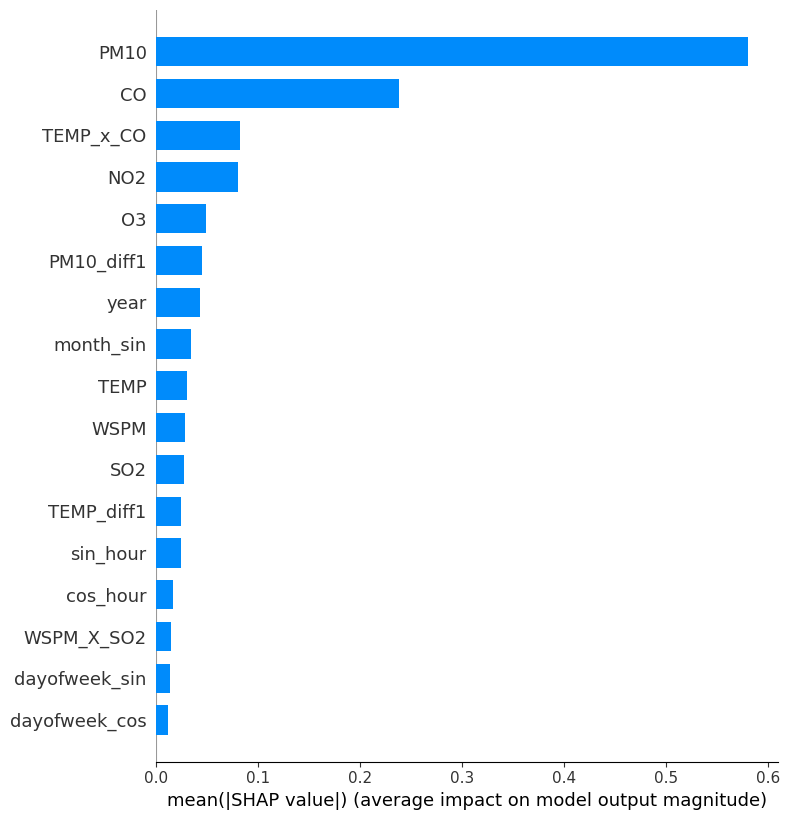

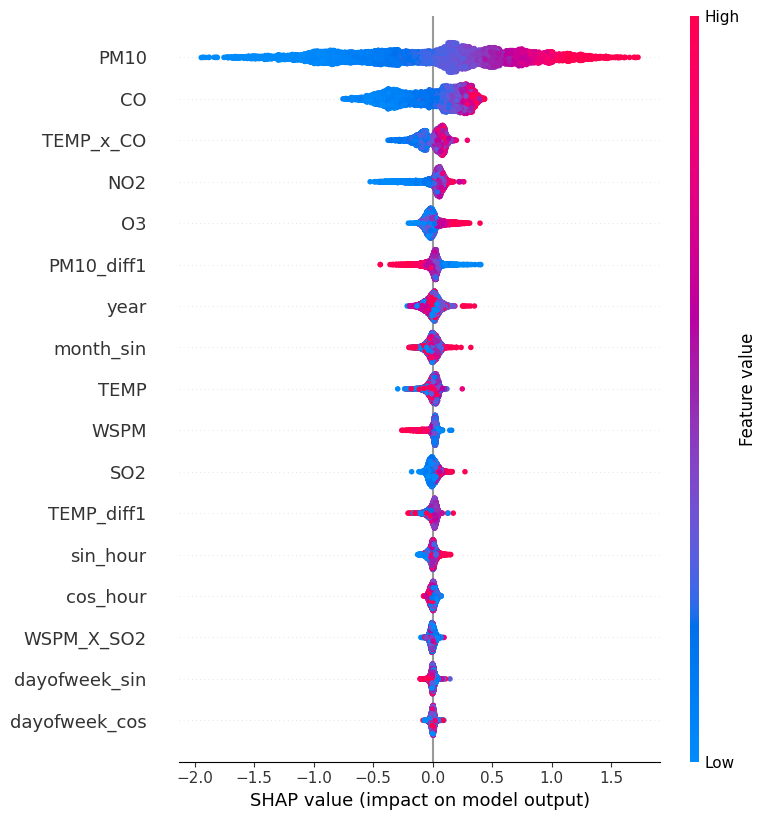

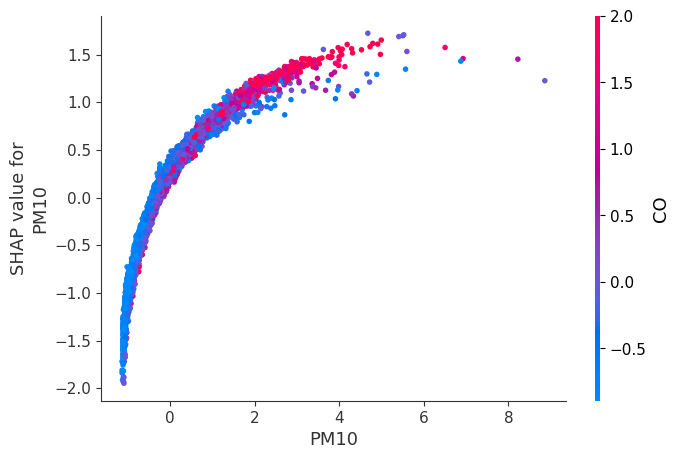

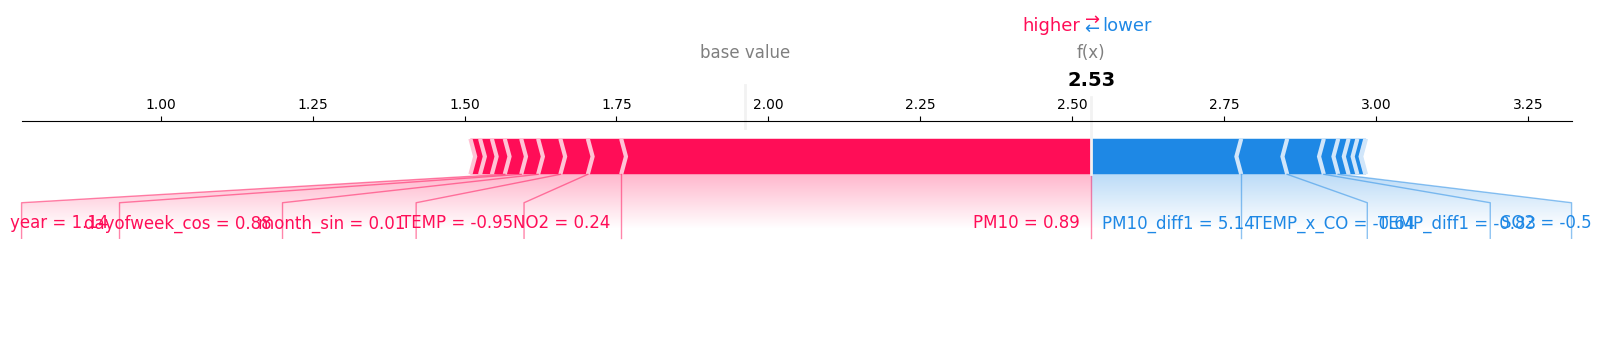

In [ ]:
# shap doesn't work with ensembles directly, that's why we are computing the separately and then averaging (since it's what an ensemble is)
explainer_cat = shap.TreeExplainer(best_cat_model) 
shap_values_cat = explainer_cat.shap_values(X_test)

explainer_xgboost = shap.TreeExplainer(best_xgboost_model)
shap_values_xgboost = explainer_xgboost.shap_values(X_test)

shap_values_ensemble = (shap_values_cat + shap_values_xgboost) / 2
explainer_ensemble = (explainer_cat.expected_value + explainer_xgboost.expected_value) / 2

# Mean absolute SHAP value bar plot → Shows average feature importance across the dataset
shap.summary_plot(shap_values_ensemble, X_test, plot_type="bar", show=True, rng=RANDOM_SEED)

# Summary plot (beeswarm plot) → Shows distribution of SHAP values per feature, with colour showing feature magnitude.
shap.summary_plot(shap_values_ensemble, X_test, show=True, rng=RANDOM_SEED)

# SHAP dependence plot with interaction → Shows how the SHAP value of one feature changes with its value and highlights interaction with another feature.
most_important_feature = X_test.columns[abs(shap_values_ensemble).mean(axis=0).argmax()]
shap.dependence_plot(most_important_feature, shap_values_ensemble, X_test, show=True)

# SHAP force plot (individual prediction) → Shows how each feature pushes predictions up or down for one sample.
resid = y_test - ensemble_predictions
big_errors = np.argsort(np.abs(resid))[-1]  # Index of worst prediction

shap.force_plot(explainer_ensemble, shap_values_ensemble[big_errors], np.around(X_test.iloc[big_errors, :], 2), matplotlib=True)

In [ ]:
# Get the input features for the outlier
outlier_input = X_test.iloc[big_errors, :]

# Get the predicted value for the outlier
outlier_pred = ensemble_predictions[big_errors]

# Get the ground truth for the outlier
outlier_true = y_test.iloc[big_errors]

# Calculate the prediction error
outlier_error = outlier_pred - outlier_true

# Display the results
print("Input features for the outlier (original scale):")
print(np.exp(outlier_input))

print(f"\nPredicted value (original scale): {np.exp(outlier_pred)}")
print(f"Ground truth (original scale): {np.exp(outlier_true)}")
print(f"Prediction error (original scale): {np.exp(outlier_pred) - np.exp(outlier_true)}")


Input features for the outlier:
year               3.114442
PM10               2.425254
SO2                0.603729
NO2                1.274631
CO                 0.801782
O3                 0.498756
TEMP               0.388130
WSPM               0.603158
sin_hour           0.255109
cos_hour           0.693491
month_sin          1.007012
dayofweek_sin      3.025526
dayofweek_cos      2.412046
TEMP_x_CO          0.528921
WSPM_X_SO2         0.594730
PM10_diff1       171.374734
TEMP_diff1         0.434259
Name: 2016-12-13 17:00:00, dtype: float64

Predicted value (original scale): 91.4052050357972
Ground truth (original scale): 3.0000000000000004
Prediction error (original scale): 88.4052050357972


##### Predicted value significantly different from true value. The model expected high PM2.5 mainly because of high PM10 and CO. The error is likely because of high PM10_diff1. The feature reduces variance and gets us a better score, but trade-offs like this exist.

##### The model’s understanding is physically reasonable: higher pollutants → higher PM2.5. No critical model flaws detected.

### Saving and loading shap values

In [77]:
np.save('shap_values_cat.npy', shap_values_cat) 
np.save('shap_values_xgboost.npy', shap_values_xgboost)

In [33]:
shap_values_cat = np.load('shap_values_cat.npy')
shap_values_xgboost = np.load('shap_values_xgboost.npy')

## Residual Plot

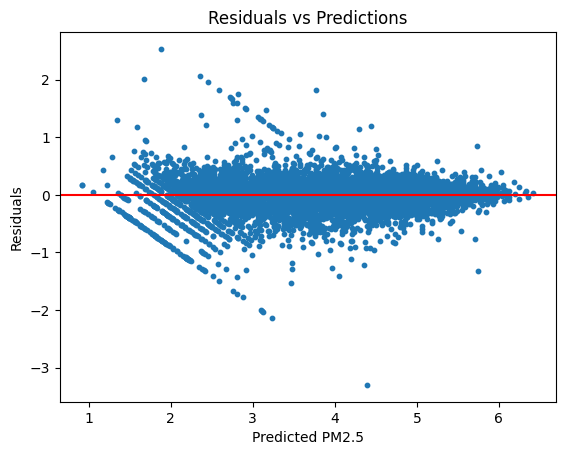

In [78]:
pred = best_ensemble.predict(X_test)
resid = y_test - pred

plt.scatter(pred, resid, s=10)
plt.axhline(0, color='red')
plt.xlabel(f'Predicted {TARGET}')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.show()

- Residuals scatter around zero but increase in spread for very high predicted values. These plots exhibit “heteroscedasticity”, as being established before. 
- Model struggles more at extreme predicted values. Some systematic error is present at the tails.
- The middle range is acceptable.

## Q-Q Plot
##### Check whether residuals behave as expected (normal distribution)

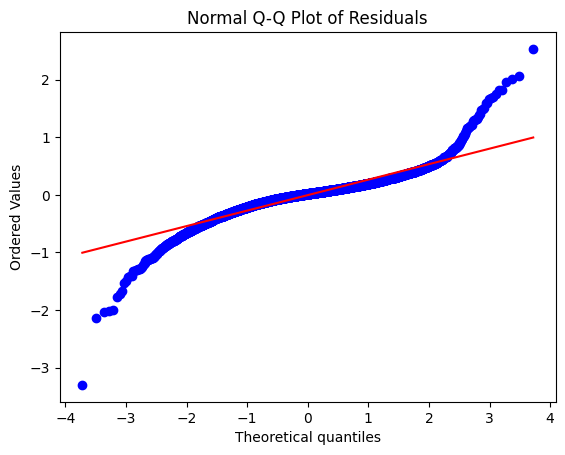

In [79]:
stats.probplot(resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Residuals')
plt.show()

#### Residuals follow the diagonal in the middle but deviate significantly in both tails.

## Addressing heavy tails

### Instead of predicting the mean (usual regression), predicting a quantile

##### It helps when errors are not uniform across the target range, especially for heteroscedasticity. It allows the model to predict the conditional median (less sensitive to outliers) or other quantiles (for tail focus).

In [67]:
best_catBoostRegressor_params

{'loss_function': 'RMSE',
 'n_estimators': 1500,
 'max_depth': 13,
 'learning_rate': 0.16,
 'random_seed': 42,
 'verbose': 0}

In [68]:
df_results = pd.DataFrame({
        'quantile': pd.Series(dtype='float'),
        'MAE': pd.Series(dtype='float'),
        'RMSE': pd.Series(dtype='float'),
        'R2': pd.Series(dtype='float'),
    })

for quantile in (0.5, 0.55, 0.6, 0.65, 0.7, 0.75):

    model = CatBoostRegressor(
        loss_function=f'Quantile:alpha={quantile}',
        n_estimators=1500,
        max_depth=13,
        learning_rate=0.16,
        random_seed=RANDOM_SEED,
        verbose=0
    )

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = mae_exp(y_test, predictions)
    rmse = rmse_exp(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Test \tMAE: {mae}")
    print(f"Test \tRMSE: {rmse}")
    print(f"Test \tR2: {r2}")

    new_row_df = pd.DataFrame({'quantile': [quantile],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R2': [r2],
                            })

    df_results = pd.concat([df_results, new_row_df], ignore_index=True)

Test 	MAE: 11.963597548792793
Test 	RMSE: 21.457060080505894
Test 	R2: 0.9238158678068538
Test 	MAE: 11.739501861149778
Test 	RMSE: 20.811898331679515
Test 	R2: 0.9215257965647884
Test 	MAE: 11.901170084220704
Test 	RMSE: 20.865104765595596
Test 	R2: 0.9210460506159057
Test 	MAE: 11.885616035321634
Test 	RMSE: 21.160224367464842
Test 	R2: 0.9221039608905139
Test 	MAE: 11.96345927497609
Test 	RMSE: 21.015433751208136
Test 	R2: 0.9179637163737173
Test 	MAE: 12.055981265381476
Test 	RMSE: 21.32887639108784
Test 	R2: 0.9173409237279174


In [69]:
df_results

,quantile,MAE,RMSE,R2
0,0.50,11.963598,21.457060,0.923816
1,0.55,11.739502,20.811898,0.921526
2,0.60,11.901170,20.865105,0.921046
3,0.65,11.885616,21.160224,0.922104
4,0.70,11.963459,21.015434,0.917964
5,0.75,12.055981,21.328876,0.917341


##### The best is 0.55. Its metrics aren't superior to already existent models.

### Instance Weighing
##### To Give higher weight to rare or large target values during training.

In [14]:
df_results = pd.DataFrame({
        'quantile': pd.Series(dtype='float'),
        'MAE': pd.Series(dtype='float'),
        'RMSE': pd.Series(dtype='float'),
        'R2': pd.Series(dtype='float'),
    })

for quantile in (0.7, 0.75, 0.8, 0.85, 0.9, 0.95):
    weights = np.where(y_train > y_train.quantile(quantile), 3, 1)  # Give 3x weight to large targets

    model = CatBoostRegressor(
    n_estimators=1500,
    max_depth=13,
    learning_rate=0.16,
    random_seed=RANDOM_SEED,
    verbose=0
    )

    model.fit(X_train, y_train, sample_weight=weights)
    predictions = model.predict(X_test)

    mae = mae_exp(y_test, predictions)
    rmse = rmse_exp(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Test \tMAE: {mae}")
    print(f"Test \tRMSE: {rmse}")
    print(f"Test \tR2: {r2}")

    new_row_df = pd.DataFrame({'quantile': [quantile],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R2': [r2],
                            })

    df_results = pd.concat([df_results, new_row_df], ignore_index=True)

Test 	MAE: 10.337702458665612
Test 	RMSE: 18.19036744878149
Test 	R2: 0.9361049961153276
Test 	MAE: 10.384606617123438
Test 	RMSE: 18.43386775181794
Test 	R2: 0.9356995850332037
Test 	MAE: 10.447152001261326
Test 	RMSE: 18.694060351909556
Test 	R2: 0.9354178694009313
Test 	MAE: 10.343698493230576
Test 	RMSE: 18.278910709990296
Test 	R2: 0.9372359172422946
Test 	MAE: 10.513135714982852
Test 	RMSE: 18.632862927776397
Test 	R2: 0.9362056515895143
Test 	MAE: 10.723944385084296
Test 	RMSE: 18.956449233680495
Test 	R2: 0.9347728573709627


In [17]:
df_results

,quantile,MAE,RMSE,R2
0,0.70,10.337702,18.190367,0.936105
1,0.75,10.384607,18.433868,0.935700
2,0.80,10.447152,18.694060,0.935418
3,0.85,10.343698,18.278911,0.937236
4,0.90,10.513136,18.632863,0.936206
5,0.95,10.723944,18.956449,0.934773


In [ ]:
df_results2 = pd.DataFrame({
        'weight': pd.Series(dtype='float'),
        'MAE': pd.Series(dtype='float'),
        'RMSE': pd.Series(dtype='float'),
        'R2': pd.Series(dtype='float'),
    })

for weight in (1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5):
    weights = np.where(y_train > y_train.quantile(0.7), weight, 1)

    model = CatBoostRegressor(
    n_estimators=1500,
    max_depth=13,
    learning_rate=0.16,
    random_seed=RANDOM_SEED,
    verbose=0
    )

    model.fit(X_train, y_train, sample_weight=weights)
    predictions = model.predict(X_test)

    mae = mae_exp(y_test, predictions)
    rmse = rmse_exp(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Test \tMAE: {mae}")
    print(f"Test \tRMSE: {rmse}")
    print(f"Test \tR2: {r2}")

    new_row_df = pd.DataFrame({'weight': [weight],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R2': [r2],
                            })

    df_results2 = pd.concat([df_results2, new_row_df], ignore_index=True)

Test 	MAE: 10.649970765917113
Test 	RMSE: 19.004142983717646
Test 	R2: 0.9360001116121881
Test 	MAE: 10.58216786182098
Test 	RMSE: 18.95333745392217
Test 	R2: 0.9348375225724864
Test 	MAE: 10.49593423352504
Test 	RMSE: 18.680665322640596
Test 	R2: 0.9352924318140188
Test 	MAE: 10.337702458665612
Test 	RMSE: 18.19036744878149
Test 	R2: 0.9361049961153276
Test 	MAE: 10.371510892906793
Test 	RMSE: 18.28863730319183
Test 	R2: 0.9363151285286967
Test 	MAE: 10.320959792531415
Test 	RMSE: 18.267060020099294
Test 	R2: 0.9356355911197947
Test 	MAE: 10.204658958985505
Test 	RMSE: 17.927377240535304
Test 	R2: 0.9363716178083245
Test 	MAE: 10.289145327688114
Test 	RMSE: 18.38768045641848
Test 	R2: 0.9368871302415155


In [19]:
df_results2

,weight,MAE,RMSE,R2
0,1.5,10.649971,19.004143,0.936000
1,2.0,10.582168,18.953337,0.934838
2,2.5,10.495934,18.680665,0.935292
3,3.0,10.337702,18.190367,0.936105
4,3.5,10.371511,18.288637,0.936315
5,4.0,10.320960,18.267060,0.935636
6,4.5,10.204659,17.927377,0.936372
7,5.0,10.289145,18.387680,0.936887


##### The best weight is `4.5`. The metrics are better than the best ensemble so far.

In [70]:
weights = np.where(y_train > y_train.quantile(0.7), 4.5, 1)  # Give 4.5x weight to large targets

best_cat_model = CatBoostRegressor(
    n_estimators=1500,
    max_depth=13,
    learning_rate=0.16,
    random_seed=RANDOM_SEED,
    verbose=0
)

best_cat_model.fit(X_train, y_train, sample_weight=weights)
predictions = best_cat_model.predict(X_test)

mae = mae_exp(y_test, predictions)
rmse = rmse_exp(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 10.204658958985505
Test 	RMSE: 17.927377240535304
Test 	R2: 0.9363716178083245


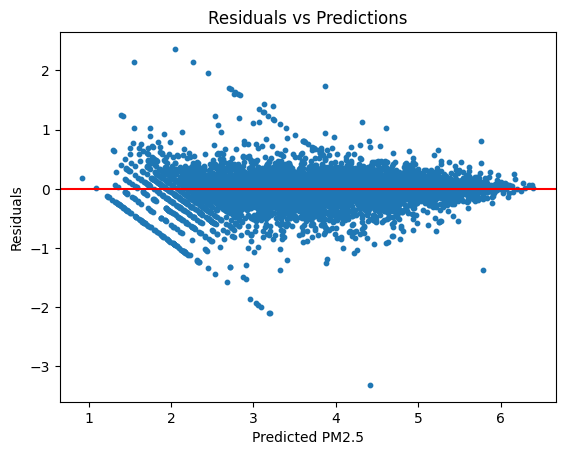

In [71]:
resid = y_test - predictions

plt.scatter(predictions, resid, s=10)
plt.axhline(0, color='red')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.show()

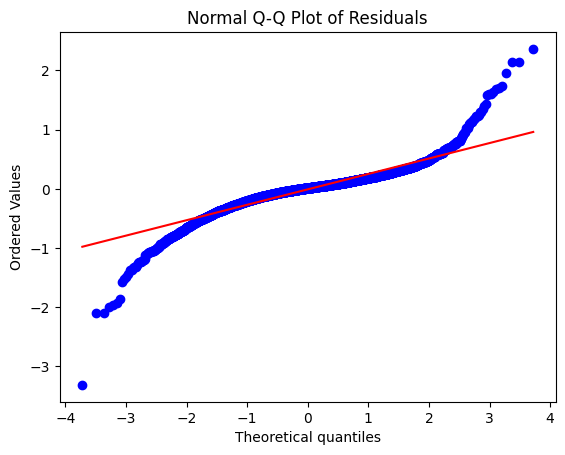

In [72]:
stats.probplot(resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Residuals')
plt.show()

##### Saving the best model

In [73]:
best_cat_model.save_model('best_cat_model.cbm')

### XGBoost weighing

In [26]:
df_results = pd.DataFrame({
        'quantile': pd.Series(dtype='float'),
        'MAE': pd.Series(dtype='float'),
        'RMSE': pd.Series(dtype='float'),
        'R2': pd.Series(dtype='float'),
    })

for quantile in (0.7, 0.75, 0.8, 0.85, 0.9, 0.95):
    weights = np.where(y_train > y_train.quantile(quantile), 3, 1)

    model = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    booster= 'gbtree',
    n_estimators= 4900,
    learning_rate= 0.08,
    random_state= 42
    )

    model.fit(X_train, y_train, sample_weight=weights)
    predictions = model.predict(X_test)

    mae = mae_exp(y_test, predictions)
    rmse = rmse_exp(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Test \tMAE: {mae}")
    print(f"Test \tRMSE: {rmse}")
    print(f"Test \tR2: {r2}")

    new_row_df = pd.DataFrame({'quantile': [quantile],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R2': [r2],
                            })

    df_results = pd.concat([df_results, new_row_df], ignore_index=True)

Test 	MAE: 10.91745342961208
Test 	RMSE: 19.161427003811266
Test 	R2: 0.930361151380778
Test 	MAE: 10.9101485898488
Test 	RMSE: 18.725564412964687
Test 	R2: 0.9306536569866379
Test 	MAE: 10.932181391148664
Test 	RMSE: 18.547059922194926
Test 	R2: 0.9316282640747722
Test 	MAE: 10.96514239041696
Test 	RMSE: 18.738386242017643
Test 	R2: 0.9315949674233837
Test 	MAE: 10.94516892004388
Test 	RMSE: 18.671714937102326
Test 	R2: 0.9321325198570923
Test 	MAE: 10.982505610359144
Test 	RMSE: 18.701468700387604
Test 	R2: 0.9317467236871477


In [27]:
df_results

,quantile,MAE,RMSE,R2
0,0.70,10.917453,19.161427,0.930361
1,0.75,10.910149,18.725564,0.930654
2,0.80,10.932181,18.547060,0.931628
3,0.85,10.965142,18.738386,0.931595
4,0.90,10.945169,18.671715,0.932133
5,0.95,10.982506,18.701469,0.931747


In [28]:
df_results2 = pd.DataFrame({
        'weight': pd.Series(dtype='float'),
        'MAE': pd.Series(dtype='float'),
        'RMSE': pd.Series(dtype='float'),
        'R2': pd.Series(dtype='float'),
    })

for weight in (1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5):
    weights = np.where(y_train > y_train.quantile(0.8), weight, 1)

    model = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    booster= 'gbtree',
    n_estimators= 4900,
    learning_rate= 0.08,
    random_state= 42
    )

    model.fit(X_train, y_train, sample_weight=weights)
    predictions = model.predict(X_test)

    mae = mae_exp(y_test, predictions)
    rmse = rmse_exp(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Test \tMAE: {mae}")
    print(f"Test \tRMSE: {rmse}")
    print(f"Test \tR2: {r2}")

    new_row_df = pd.DataFrame({'weight': [weight],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R2': [r2],
                            })

    df_results2 = pd.concat([df_results2, new_row_df], ignore_index=True)

Test 	MAE: 11.060010859067305
Test 	RMSE: 19.31691591361796
Test 	R2: 0.9305086708852052
Test 	MAE: 10.947619683219537
Test 	RMSE: 18.776819693407305
Test 	R2: 0.9314341688812273
Test 	MAE: 10.919788028962847
Test 	RMSE: 18.792537580274153
Test 	R2: 0.9314025932127739
Test 	MAE: 10.932181391148664
Test 	RMSE: 18.547059922194926
Test 	R2: 0.9316282640747722
Test 	MAE: 10.945789812619687
Test 	RMSE: 18.677794685611275
Test 	R2: 0.9309509912485159
Test 	MAE: 10.891727663421259
Test 	RMSE: 18.362199722450324
Test 	R2: 0.9310174938251943
Test 	MAE: 10.910623103802392
Test 	RMSE: 18.630354608450695
Test 	R2: 0.9300908908387875
Test 	MAE: 10.92406921397345
Test 	RMSE: 18.892749367551417
Test 	R2: 0.9306386171565519


In [29]:
df_results2

,weight,MAE,RMSE,R2
0,1.5,11.060011,19.316916,0.930509
1,2.0,10.947620,18.776820,0.931434
2,2.5,10.919788,18.792538,0.931403
3,3.0,10.932181,18.547060,0.931628
4,3.5,10.945790,18.677795,0.930951
5,4.0,10.891728,18.362200,0.931017
6,4.5,10.910623,18.630355,0.930091
7,5.0,10.924069,18.892749,0.930639


In [30]:
weights = np.where(y_train > y_train.quantile(0.8), 4, 1)  # Give 4.0x weight to large targets

model = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    booster= 'gbtree',
    n_estimators= 4900,
    learning_rate= 0.08,
    random_state= 42
)

model.fit(X_train, y_train, sample_weight=weights)
predictions = model.predict(X_test)

mae = mae_exp(y_test, predictions)
rmse = rmse_exp(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 10.891727663421259
Test 	RMSE: 18.362199722450324
Test 	R2: 0.9310174938251943


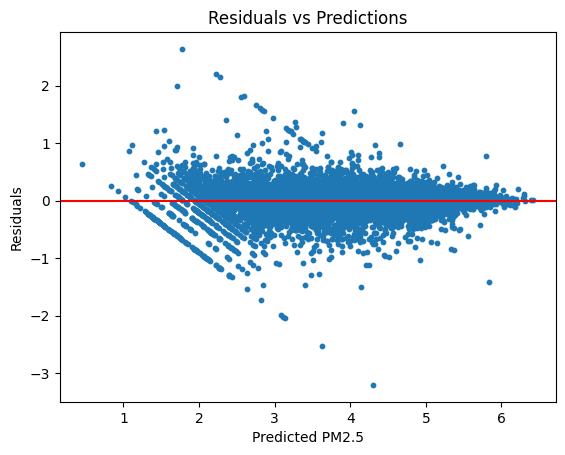

In [31]:
resid = y_test - predictions

plt.scatter(predictions, resid, s=10)
plt.axhline(0, color='red')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.show()

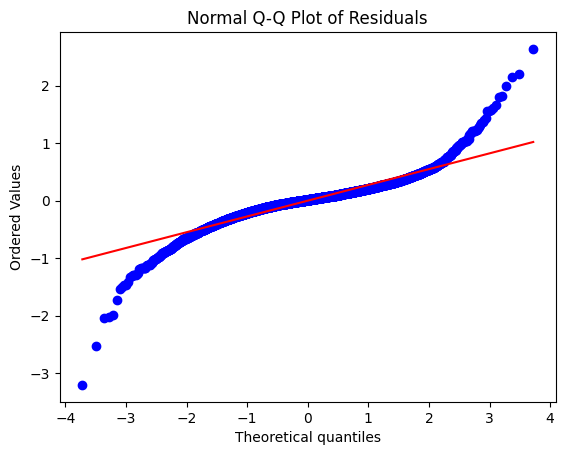

In [32]:
stats.probplot(resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Residuals')
plt.show()

## Conclusion

##### The residual distribution, while improved, does not fully satisfy the assumption of homoscedasticity. The remaining "striped" patterns suggest that the model systematically over- or under-predicts for specific data segments, which a tree-based model inherently struggles to resolve due to its stepwise approximation nature.

#### Throughout this project, key challenges included:
- managing an imbalanced and heteroscedastic target variable
- feature engineering that occasionally degraded performance despite theoretical justification.
- the trade-off between predictive accuracy (RMSE) and residual distribution improvement (MAE and tail behavior)


#### The final model follows `CatBoostRegression` algorithm and the best scores and parameters exhibit:

|Best model | n_estimators | max_depth | learning_rate | sample_weight | MAE | RMSE | R2 |
|-----|-----|-----|-----|-----|-----|-----|-----|
| CatBoost | 1500 | 13 | 0.16 | > quantile(0.7), x4.5 | 10.205 | 17.927 | 0.936 |

##### This work demonstrates that, for this problem, additional model complexity is not warranted. Instead, data enrichment or further exploration of the underlying data generation process is likely more beneficial than pursuing algorithmic sophistication.